In [1]:
#from collections import defaultdict
#import itertools
#import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import yaml
import os
from coco import COCO

/cluster/home/solveijm/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Read YAML file
with open("config.yaml", 'r') as stream:
    config_file = yaml.safe_load(stream)

DATASET_DIR = config_file['dataset_src_dir']
    
TRAIN_PATH = os.path.join(DATASET_DIR, config_file['train'])
VAL_PATH = os.path.join(DATASET_DIR, config_file['val'])
TEST_PATH = os.path.join(DATASET_DIR, config_file['test'])

IMAGES_PATH = os.path.join(DATASET_DIR, 'images/')


In [3]:
dataset_path = os.path.join(DATASET_DIR, 'coco_hurtigruten.json')
data = COCO(dataset_path)
CLASSES = {id: cat['name'] for id, cat in data.cats.items()}

creating index...
index created!


In [4]:
catIds = list(CLASSES.keys())
catIds.sort()
sorted_class_names = [CLASSES[id] for id in catIds]
dataset_info = {'path': DATASET_DIR, 'train': config_file['train'], 'val': config_file['val'], 'test': config_file['test'], 'nc': len(CLASSES), 'names': sorted_class_names}

In [5]:

# Read YAML file
with open("dataset.yaml", 'w+') as file:
    yaml.dump(dataset_info, file)

In [6]:
numb_images = len(data.imgs)
print('Number of images: ', numb_images)
numb_of_categories = len(data.cats)
print('Number of classes:', numb_of_categories)
print('Classes:', [cat['name'] for cat in data.cats.values()])

Number of images:  4994
Number of classes: 26
Classes: ['open_pleasure_craft', 'rhib', 'semi_open_pleasure_craft', 'fishing_vessel', 'enclosed_pleasure_craft', 'Tugs', 'other_passenger_vessel', 'unspecified', 'kayak', 'catamaran_express_ferry', 'buoys', 'supply_vessel', 'cargo_vessel', 'container_vessel', 'ferry', 'sailboat_motor', 'yacht', 'sailboat_sail', 'rescue_vessel', 'cruise_vessel', 'sailboat_motor_multiple', 'sailboat_sail_multiple', 'fish_farm', 'barge', 'jetski', 'ro_ro_vessel']


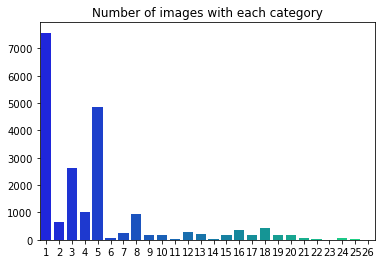

{1: 'open_pleasure_craft', 2: 'rhib', 3: 'semi_open_pleasure_craft', 4: 'fishing_vessel', 5: 'enclosed_pleasure_craft', 6: 'Tugs', 7: 'other_passenger_vessel', 8: 'unspecified', 9: 'kayak', 10: 'catamaran_express_ferry', 11: 'buoys', 12: 'supply_vessel', 13: 'cargo_vessel', 14: 'container_vessel', 15: 'ferry', 16: 'sailboat_motor', 17: 'yacht', 18: 'sailboat_sail', 19: 'rescue_vessel', 20: 'cruise_vessel', 21: 'sailboat_motor_multiple', 22: 'sailboat_sail_multiple', 23: 'fish_farm', 24: 'barge', 25: 'jetski', 26: 'ro_ro_vessel'}


In [7]:
cat_stats = {id : len(imgs) for id, imgs in data.catToImgs.items()}

sns.set_palette("winter", len(cat_stats))
sns.barplot(x=list(cat_stats.keys()), y= list(cat_stats.values())).set(title='Number of images with each category')
plt.show()
print(CLASSES)


### Display some images

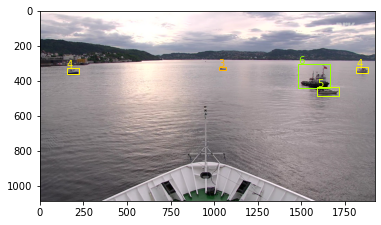

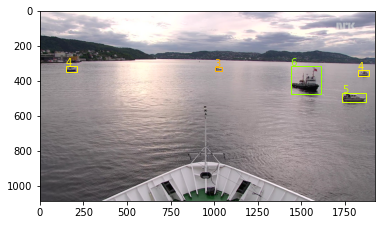

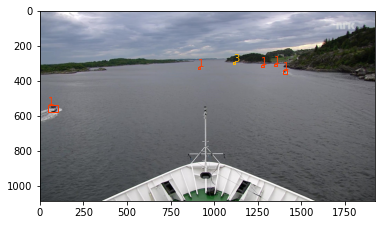

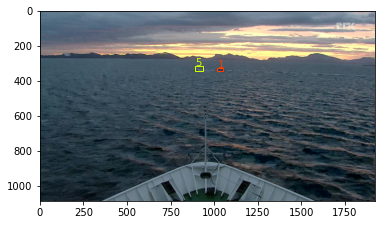

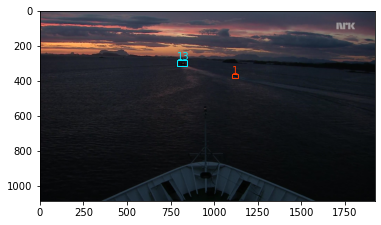

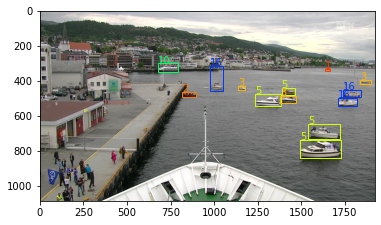

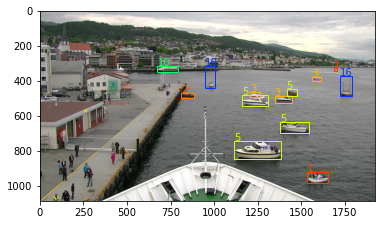

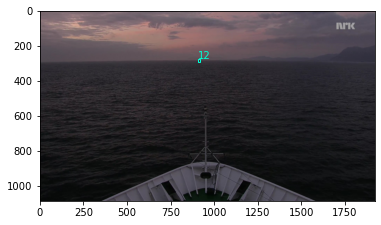

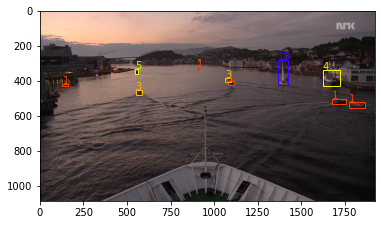

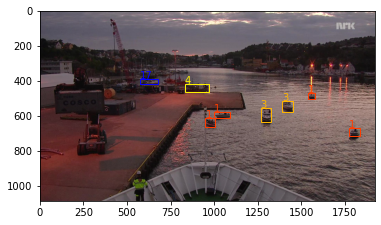

In [8]:
image_ids = [31, 32, 171, 197, 223, 367, 368, 484, 544, 553] 
#images_path = './hurtigruten/images/'

for image_id in image_ids:
    data.visualizeImage(image_id, IMAGES_PATH)

## Convert from xml to yolo format

In [9]:
from xml2yolo import xml_to_yolo

input_dir = os.path.join(DATASET_DIR, 'annotations/')
label_dir = os.path.join(DATASET_DIR , 'labels/')
image_dir = os.path.join(DATASET_DIR, 'images/')



In [ ]:
xml_to_yolo(input_dir, label_dir, image_dir, sorted_class_names)

## Split into train, val and test

In [12]:
import glob
import random

files = glob.glob(os.path.join(image_dir, '*.jpeg'))
random.shuffle(files)

folders = config_file['split']
check_sum = sum([folders[x] for x in folders])
assert check_sum == 1.0, "Split proportion is not equal to 1.0"

In [11]:
split_point_train = round(len(files)*folders['train'])
split_point_val = split_point_train + round(len(files)*folders['val'])


with open(TRAIN_PATH, 'w+') as file:
    file.write('\n'.join(str('./'+'/'.join(line.split('/')[-2:])) for line in files[:split_point_train]))

with open(VAL_PATH, 'w+') as file:
    file.write('\n'.join(str('./'+'/'.join(line.split('/')[-2:])) for line in files[split_point_train:split_point_val]))

with open(TEST_PATH, 'w+') as file:
    file.write('\n'.join(str(image_dir +'/'.join(line.split('/')[-2:])) for line in files[split_point_val:]))


In [12]:
print('# of train: ', split_point_train)
print('# of val: ', str(split_point_val-split_point_train))
print('# of test: ', str(len(files)-split_point_val))

# of train:  2576
# of val:  552
# of test:  552


## Move test images into folder

In [18]:
import shutil

In [14]:
testImages = os.path.join(DATASET_DIR, 'testImages/')
os.mkdir(testImages)

In [26]:
with open(TEST_PATH, 'r') as file:
    for line in file.readlines():
        line = line.rstrip()
        image_name = line.split('/')[-1]
        new_path = os.path.join(testImages,image_name)
        shutil.move(line, new_path)